In [3]:
from google.colab import files 
upload = files.upload()


Saving SG.txt to SG.txt


### Importing and separating the glaze data into a numpy array to convert to csv later. 

In [4]:
import csv

glazes = open("SG.txt", 'r')
lines = glazes.readlines()

c_6 = False

i = 0
with open("glazes.csv", 'w', newline = '') as c_6:
	writer = csv.writer(c_6)

	for line in lines:

		if ("C: 6\n" in line): '''Grabbing all of the Cone 6 glazes in database and
                              writing to a csv file.
                              '''
			writer.writerow([f"Cone 6:{i}"]) 
			c_6 = True
			i+=1

		if ((line[:2] == "E:" or line[:2] == "F:") and c_6 == True):
			writer.writerow([line])
                            '''Extracting only the material features from 
                            dataset as well as the F: column wich is 
                            the glaze texture that model is going to predict'''
		else: continue

	import pandas as pd 

	features = []
	for line in lines:
		if line[:2] == "E:":
			features.append(line.split(' ')[2].lower().strip("\n"))
	features = list(set(features))
 	
	labels = []
	for line in lines:
		if line[:2] == "F:":
			labels.append(line.split(' ')[1].lower().strip('\n'))
	labels = list(set(labels))
	'''
    Adding All labels and features in database to list.
  '''

dataPts = []
i = 0
for line in lines:
  if f"C: 6\n" in line:
      dataPts.append(f"Cone 6:{i}")
	

import numpy as np 
data = np.zeros((len(dataPts),len(features) +1))

"""
Creating numpy array for csv conversion
"""



Converting numpy array into a csv file as well as encoding labels for the csv file.

    

In [5]:
from sklearn import preprocessing

encoding = preprocessing.LabelEncoder()
encoding.fit(labels)

#Making encoded values on labels so I can categorize them as numbers

label_val = {i : 0 for i in labels}


with open("glazes.csv", 'r') as cones:
  i = 0
  value = ''
  for lines in cones:
    if "Cone 6:" in lines:
      i = int(lines.split(':')[1])
    if "E: " in lines:
      if '-' in lines.split(' ')[1]:
        data[i,features.index(lines.split(' ')[2].strip('\n').lower())] \
                           = lines.split(' ')[1].split('-')[0]
      elif ',' in lines.split(' ')[1]:
        data[i,features.index(lines.split(' ')[2].strip('\n').lower())] \
                           = lines.split(' ')[1].split(',')[0]
      elif '%' in lines:
        data[i,features.index(lines.split(' ')[2].strip('\n').lower())] \
                           = lines.split(' ')[1].strip('%')
      else:
        data[i,features.index(lines.split(' ')[2].strip('\n').lower())] \
                           = lines.split(' ')[1]
    elif "F: " in lines: 
      data[i,len(features)] = encoding.transform\
      ([lines.split(" ")[1].lower().strip('\n')])
      
      label_val[lines.split(" ")[1].lower().strip('\n')] +=1
      '''
      More cleaning of database extracting all non-useful characters:
      "\n", "%", "E:", "F:", and ","
      '''
      

dataFrame = pd.DataFrame(data)
dataFrame.to_csv("Glaze_data.csv")
#Converting numpy array to csv file 

Visualizing the data.

Making a pie chart for the distribution of labels in the dataset

'\nPlotting the distribution of all the different glaze types spread throught the \ndataset in a pie-chart to see what glaze type dominates the dataset.\n'

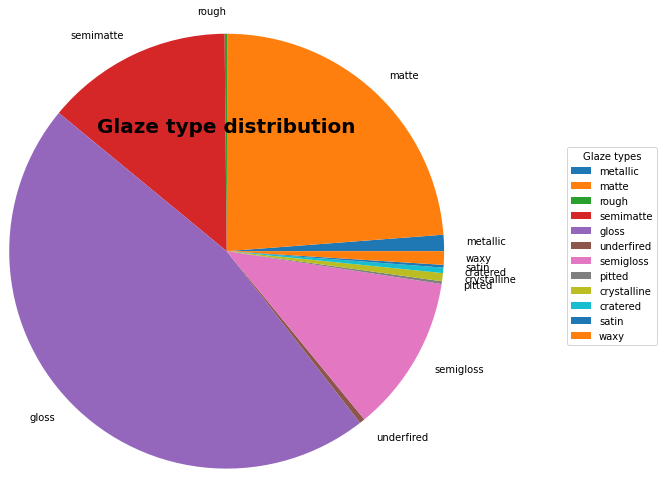

In [151]:
import matplotlib.pyplot as plt

values = list(label_val.values())

_, ax1 = plt.subplots()

_, autotexts = ax1.pie(values,labels = labels, shadow = False, radius = 2.5)

ax1.legend(labels, title = "Glaze types", loc = "upper right",\
           bbox_to_anchor=(1, 0, 1.5, 1))
plt.setp(autotexts, size = 10)
ax1.set_title("Glaze type distribution",loc = "center", \
              fontweight = "bold", fontsize = 20, verticalalignment = "bottom")
"""
Plotting the distribution of all the different glaze types spread throught the 
dataset in a pie-chart to see what glaze type dominates the dataset.
"""



Splitting dataset and training neural network.

In [148]:
from sklearn import preprocessing

np.random.shuffle(data)
dnn_features = data[:, :89]
dnn_labels = data[:, 89]

scalar = preprocessing.StandardScaler()

features_standardized = scalar.fit_transform(dnn_features)
"""
Initializing all values for material amounts in glazes to small numbers
to make all the units on the same scale for the neural network.
""" 

from sklearn.model_selection import train_test_split

features_train, features_test, target_vector_train, target_vector_test = \
                                      train_test_split(dnn_features,\
                                                       dnn_labels,
                                                    test_size = .2,
                                                    random_state = 0)

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

np.random.seed(0)

number_of_features = len(features)

target_train = to_categorical(target_vector_train)
target_test = to_categorical(target_vector_test)
"""
One-hot encoding target vectors to create target matrix.
"""


glaze_network = models.Sequential()

glaze_network.add(layers.Dense(units = len(features),
                         activation = "sigmoid",
                         input_dim = len(features)))
glaze_network.add(layers.Dense(units = 256, activation="sigmoid"))

glaze_network.add(layers.Dense(units = len(labels), activation="softmax"))

SVG(model_to_dot(glaze_network, show_shapes = True).create(prog = "dot",\
                                                     format = "svg"))
plot_model(glaze_network, show_shapes = True, to_file = "glaze_network.png")

glaze_network.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

earlystop = [EarlyStopping(monitor = "val_loss", patience = 2),
             ModelCheckpoint(filepath = "best_model.h5",
                             monitor = "val_loss",
                             save_best_only = True)]
"""
Adding Early stopping to model so the model will not overfit the data
and will stop when the loss does not improve after 2 epochs.

ModelCheckpoint is so I will save only the best model.
"""

history = glaze_network.fit(features_train, 
                      target_train,
                      epochs = 100, 
                      callbacks=earlystop,#Early Stopping to reduce overfitting
                      verbose = 2,
                      batch_size = 100,
                      validation_data = (features_test, target_test))




Epoch 1/100
4/4 - 1s - loss: 2.4375 - accuracy: 0.1381 - val_loss: 1.8070 - val_accuracy: 0.5476
Epoch 2/100
4/4 - 0s - loss: 1.8416 - accuracy: 0.4294 - val_loss: 1.4233 - val_accuracy: 0.5476
Epoch 3/100
4/4 - 0s - loss: 1.6484 - accuracy: 0.4294 - val_loss: 1.3163 - val_accuracy: 0.5476
Epoch 4/100
4/4 - 0s - loss: 1.5924 - accuracy: 0.4294 - val_loss: 1.2905 - val_accuracy: 0.5476
Epoch 5/100
4/4 - 0s - loss: 1.5656 - accuracy: 0.4595 - val_loss: 1.2989 - val_accuracy: 0.5595
Epoch 6/100
4/4 - 0s - loss: 1.5416 - accuracy: 0.4625 - val_loss: 1.2783 - val_accuracy: 0.5476
Epoch 7/100
4/4 - 0s - loss: 1.5189 - accuracy: 0.4324 - val_loss: 1.2537 - val_accuracy: 0.5476
Epoch 8/100
4/4 - 0s - loss: 1.5068 - accuracy: 0.4294 - val_loss: 1.2323 - val_accuracy: 0.5476
Epoch 9/100
4/4 - 0s - loss: 1.4824 - accuracy: 0.4414 - val_loss: 1.2215 - val_accuracy: 0.5476
Epoch 10/100
4/4 - 0s - loss: 1.4578 - accuracy: 0.4925 - val_loss: 1.2216 - val_accuracy: 0.6310
Epoch 11/100
4/4 - 0s - loss:

Printing accuracy of model.

In [149]:
import math
acc = glaze_network.evaluate(features_test, target_test)
print(acc)
"""
Printing the overall accuracy of the model on the testing data. 
"""

print(f"Model predicted {math.floor(acc[1]*100)}% of the testing set correctly")

3/3 [==============================] - 0s 3ms/step - loss: 1.0696 - accuracy: 0.6310
[1.0696067810058594, 0.6309523582458496]
Model predicted 63% of the testing set correctly


Plotting the Training and Validation   loss to see when model would start to overfit.

Also plotting the Training and Validation accuracy of model over each epoch.

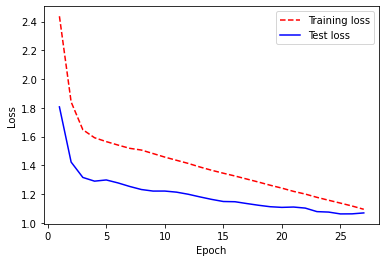

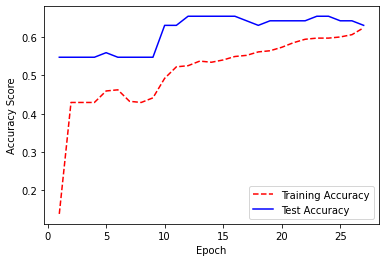

In [150]:
'''
Graphing training and validation loss
in order to see when the model starts to overfit 
the data
'''

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) +1)
plt.figure(1)
plt.plot(epochs, training_loss, "r--")
plt.plot(epochs, validation_loss, "b-")

plt.legend(["Training loss", "Test loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
'''
Graphing training and validation accuracy
over each epoch
''' 
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
plt.figure(2)
plt.plot(epochs, training_accuracy, "r--")
plt.plot(epochs, validation_accuracy, "b-")

plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()
